# This notebook is for course four : Classification Analysis (Supervised Learning)

### Importing Data Files

In [ ]:
#As part of the business objectives that you have set for Retailer X, 
#you must assist the retailer with understanding the factors that are 
#associated with the loyalty program participation to help them predict 
#in the future who is likely to participate or not. From this point, 
#Retailer X can direct the appropriate message to each customer effectively.


In [65]:
#Import Product DataSet here
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_4c73b4e9125d48cf93a58e32e4df6b8a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='OrWgd56afrWso8TP28McZnZhIVT6iLoOUxmlRw_0RAgN',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_4c73b4e9125d48cf93a58e32e4df6b8a.get_object(Bucket='datascienceproject-donotdelete-pr-knsi3l5zevhael',Key='Product Data Set - Student 2 of 3.csv')['Body']


,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [10]:
#Import Transaction DataSet Here
body = client_4c73b4e9125d48cf93a58e32e4df6b8a.get_object(Bucket='datascienceproject-donotdelete-pr-knsi3l5zevhael',Key='Transaction Data Set - Student 3 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

transaction_data = pd.read_csv(body,sep='|')
transaction_data.head()


,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [11]:
#Import Customer Dataset Here
body = client_4c73b4e9125d48cf93a58e32e4df6b8a.get_object(Bucket='datascienceproject-donotdelete-pr-knsi3l5zevhael',Key='Customer Data Set - Student 1 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customer_data=pd.read_csv(body)
customer_data.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing Data Types

In [12]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [13]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [15]:
trans_products=transaction_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [16]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [17]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [18]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [19]:
customer_prod_categ=customer_prod_categ.reset_index()

In [20]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [21]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [22]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [23]:
customer_KPIs=customer_KPIs.fillna(0)


In [24]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [25]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Classification 
The exploratory data analysis that you conducted in Course 2, “Data Understanding and Preparation” showed that the most important features regarding LOYALTY GROUP participation are EXPERIENCE SCORE, TOTAL SPENT, INCOME, and AGE.

So, you use these features to create some classification models. However, you try different models and varied combination of features and contrast their performance.

In [ ]:
#Begin Writing your code here

In [26]:
#Create a Pandas data frame containing the most relevant features and the target 
#variable by using the following code:

DF_classification=customer_all_view[['INCOME','AGE','EXPERIENCE SCORE','TOTAL SPENT','LOYALTY GROUP']]
DF_classification.head(5)

#Because “Loyalty Group” is a categorical label, we perform classification

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT,LOYALTY GROUP
0,133498,64,5,6826.770,enrolled
1,94475,42,9,5062.451,notenrolled
2,88610,40,9,8562.440,enrolled
3,84313,38,8,5522.694,enrolled
4,51498,30,3,213.512,notenrolled


In [27]:
#Separate the target from the numerical input features (predictors) and 
#create a Pandas data frame to hold only the target labels by using the following code:

target_feature = pd.DataFrame(DF_classification['LOYALTY GROUP'])
print(type(target_feature))
target_feature.head(5)

<class 'pandas.core.frame.DataFrame'>


,LOYALTY GROUP
0,enrolled
1,notenrolled
2,enrolled
3,enrolled
4,notenrolled


In [28]:
#Drop the categorical target from the “DF_classification” Pandas data frame 
#because you are scaling the columns of this data frame and you will later 
#merge the target with the scaled Pandas data frame. Use the following code:

DF_classification = DF_classification.drop(['LOYALTY GROUP'],axis=1)
DF_classification.head(5)
#The Pandas data frame is ready for scaling.

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT
0,133498,64,5,6826.770
1,94475,42,9,5062.451
2,88610,40,9,8562.440
3,84313,38,8,5522.694
4,51498,30,3,213.512


In [29]:
#Scaling adjustment. You are using the Min-Max scaling approach, 
#which is shown in the following equation:Xsc = X - Xmin/Xmax - Xmin
#Import the pre-processing library by using the following code:
from sklearn import preprocessing

In [30]:
#Save the column names of the input Pandas data frame in a 
#list before scaling by using the following code:
DF_classification_column_names = DF_classification.columns.values
#You save the columns names because when you apply the preprocessing command to 
#a Pandas data frame, the output is a NumPy array and the column names are lost.
#To reconstruct the same data frame after scaling, you need the column names.

In [31]:
#Add the following line to adjust the scales of the input features by using the following code:

DF_classification=preprocessing.minmax_scale(DF_classification)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  app.launch_new_instance()


In [32]:
#Reconstruct the input Pandas data frame from the NumPy array by using the following code:

DF_classification=pd.DataFrame(DF_classification, columns=DF_classification_column_names)
DF_classification.head(5)
#The output shows that the four features were scaled to the 0 - 1 range.

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT
0,0.872818,0.638889,0.444444,0.446532
1,0.572046,0.333333,0.888889,0.330790
2,0.526842,0.305556,0.888889,0.560394
3,0.493722,0.277778,0.777778,0.360983
4,0.240799,0.166667,0.222222,0.012694


In [33]:
#Concatenate the DF_classification with the target_feature data frame by using the following code:

DF_classification = pd.concat([DF_classification,target_feature], axis=1)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT,LOYALTY GROUP
0,0.872818,0.638889,0.444444,0.446532,enrolled
1,0.572046,0.333333,0.888889,0.330790,notenrolled
2,0.526842,0.305556,0.888889,0.560394,enrolled
3,0.493722,0.277778,0.777778,0.360983,enrolled
4,0.240799,0.166667,0.222222,0.012694,notenrolled


In [34]:
#Partitioning input data into training and testing splits
#Import the train_test_split library by using the following code:
from sklearn.model_selection import train_test_split

In [35]:
#Run the following code to generate the training and testing data sets:
X_train,X_test,Y_train,Y_test = \
train_test_split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']],DF_classification['LOYALTY GROUP'], test_size=0.2,random_state=42)

#This code divides the input feature data frame by (80% - 20%) into two mutually exclusive Pandas data 
#frames (X_train(80%) for training and X_test(20%) for testing). It also separates the target feature 
#(class label) of both data sets into two separate data frames (Y_train for training and Y_test is for testing)
#The random_state parameter is a pseudo-random number generator state that is used for random sampling when 
#splitting the input data into training and testing splits. If this number is set, then each time you run this 
#code, you get the same training and testing data splits. If the number is not specified, then you get different 
#data sets each time. In this example, we chose to set it so that when the code is run, you get the same results 
#as those in the document.


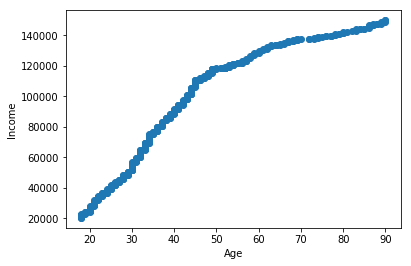

In [42]:
#age is removed from the training dataset since it has a higher correlation to income
#Verify the relationship between both variables by using the following code:
import matplotlib.pyplot as plt 
plt.scatter(customer_all_view['AGE'],customer_all_view['INCOME'])
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

In [43]:
#Training a K-Nearest Neighbor Classifier
#Complete the following steps:
from sklearn.neighbors import KNeighborsClassifier
#Create an instance of the KNN classifier by using the following code. As an initial setting, you use the eight 
#nearest neighbors to classify the output. Later, you drive the optimal k by using cross-validation.
clf_kNN = KNeighborsClassifier(n_neighbors=8)

In [44]:
#Observe the algorithm parameters by issuing the classifier instance name by using the following code:

clf_kNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')

In [45]:
#The n_neighbors = 8 value is what we specified. The rest of the parameters are assigned the default values and are explained as follows:
#Algorithm: This is the method or the algorithm that is used to calculate the nearest neighbors. It is set to auto, which means that the KNN attempts to decide the most appropriate algorithm based on the values that are passed to the fit method. The fit method is explained soon.
#Leaf size: This parameter specifies the number of points that are used to calculate the nearest neighbor points. It can significantly impact the speed of the calculations and the memory that is required.
#Metric: The distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.
#Weights: The weight function that is used in prediction. Uniform weights mean that all points in each neighborhood are weighted equally.

In [46]:
#Train the KNN classifier by using the fit function by using the following code:

clf_kNN.fit(X_train, Y_train)

#The function fit(X, y) trains the model by using X as the training data and y as the target values. It accepts input data as Pandas data frames.

type(X_train)

pandas.core.frame.DataFrame

In [47]:
#To test the model, first use the model to predict the labels of the testing feature set by using the following code:

predicted = clf_kNN.predict(X_test)

#This line returns the predicted labels of the test data in a numpy array. Run a type command to verify.

type(predicted)

numpy.ndarray

In [48]:
#Compare the predicted values to the actual values of the testing target labels (Y_test) by performing the following steps:
#Use scikit, which is a metrics library that evaluates the performance of the classifier
#Import the library by using the following code:
from sklearn import metrics

In [49]:
#Testing
#Compare the predicted values to the actual values of the testing target labels (Y_test) by performing the following steps:

acc = metrics.accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (metrics.classification_report(Y_test,predicted))

accuracy = 79.0%
              precision    recall  f1-score   support

    enrolled       0.73      0.92      0.82        51
 notenrolled       0.89      0.65      0.75        49

   micro avg       0.79      0.79      0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100



In [50]:
#The output shows the following information:
#An overall accuracy of 79% means that the model was able to predict correctly the labels of 79% of the input testing data set.
#Each class label (enrolled or not enrolled) is treated separately as follows: (Hint: Remember the confusion matrix.)
#Enrolled:
#It has a precision of 73%, which means that the whenever the model predicts or outputs “enrolled”, you can trust it by 73%.
#It has a recall of 89%, which means that whenever the true label of an unknown input sample is “enrolled”, the model can predict it correctly by 89%.
#It has an f1-score of 82%, which is a weighted sum of the precision and recall.
#Not enrolled:
#It has a precision of 89%, which means that the whenever the model predicts “not enrolled”, you can trust it by 89%.
#It has a recall of 65%, which means that whenever the true label of an unknown input sample is “not enrolled”, the model can predict it correctly by 65%.
#It has an f1-score of 75%, which is a weighted sum of the precision and recall.
#Support is the actual number of class labels.

In [55]:
#Training using the decision tree classifier
from sklearn.tree import DecisionTreeClassifier


In [57]:
#Create an instance of the algorithm with criterion = entropy by using the following code:
#We set the criterion = “entropy”. Entropy is the algorithm that the decision trees use to split nodes. 
#For more information about the other model parameters, clf = DecisionTreeClassifier(random_state=0)
#see http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.

clf_Tree=DecisionTreeClassifier(criterion='entropy',random_state=0)

In [58]:
#Observe the algorithm parameters by issuing the classifier instance name by using the following code:
clf_Tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [59]:
#Like what you did with the KNN model, train and test the tree model by using the following code:

clf_Tree.fit(X_train, Y_train)
predicted = clf_Tree .predict(X_test)
acc = metrics.accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (metrics.classification_report(Y_test,predicted))

accuracy = 75.0%
              precision    recall  f1-score   support

    enrolled       0.74      0.78      0.76        51
 notenrolled       0.76      0.71      0.74        49

   micro avg       0.75      0.75      0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



In [60]:
#Decision trees have an advantage over KNN in that they provide numerical 
#values for the feature importance. You can use this feature to provide Retailer X 
#with the most important factors that affect loyalty program participation among customers. 
#Use the feature_importances_ method to get the feature importance by using the following code:

clf_Tree.feature_importances_

array([0.26796289, 0.39545388, 0.33658323])

In [61]:
#We fed the features to the model in the following order by using the following code(in line 35):

#DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]

#So, the order of importance of the features is as follows:

#1.TOTAL SPENT
#2.INCOME
#3.EXPERIENCE SCORE

# #K-fold cross-validation to test which classifier performed best

In [62]:
from sklearn.model_selection import KFold

In [63]:
#Define a new generic training and testing function with accuracy as the performance metric by using the following code:

def Training_Testing_Accuracy_Only(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels)
    predicted = model.predict(test_data)
    acc = metrics.accuracy_score(test_labels,predicted)
    print ('accuracy = '+str(acc*100)+'%')
    return(acc)
#the code performs the following functions:
#It has five arguments as inputs: The classifier model (model), the training data (train_data), the training labels (train_labels), testing data (test_data), and testing labels (test_labels).
#It trains the model by using the function “.fit()”.
#It predicts the class labels of the testing feature set and saves them to a list called “predicted”.
#It compares the predicted output with the actual labels (“test_labels”) and calculates the accuracy (“acc”) by using a function that is called “metrics.accuracy_score()”. Then, it prints the output and returns the accuracy.

In [66]:
#Set the number of folds by using the following code:

kf = KFold(n_splits=10)

#We set the folds to 10. Each iteration has 450 training samples and 50 testing samples.

In [67]:
#Training and testing the decision tree model by using 10-fold cross-validation
#Declare an empty list to store the accuracy in each iteration and declare a new decision Tree classifier by using the following code:

clf_Tree=DecisionTreeClassifier(criterion='entropy')
accuracy_list=[]

In [68]:
#Train and test the decision tree model for each fold and get the overall accuracy by using the following code:
#brekdown of the code is in the ibm module
for train_index, test_index in kf.split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]):
    X=DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]
    Y=DF_classification['LOYALTY GROUP']
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    Y_train,Y_test=Y.iloc[train_index], Y.iloc[test_index]   
    accuracy=Training_Testing_Accuracy_Only(clf_Tree,X_train,Y_train,X_test,Y_test)
    accuracy_list.append(accuracy) 
print("overall_accuracy is %",100 * sum(accuracy_list)/len(accuracy_list))

accuracy = 76.0%
accuracy = 72.0%
accuracy = 72.0%
accuracy = 66.0%
accuracy = 70.0%
accuracy = 84.0%
accuracy = 70.0%
accuracy = 74.0%
accuracy = 72.0%
accuracy = 76.0%
overall_accuracy is % 73.2


In [69]:
#Training and testing the K-Nearest Neighbor classifier with a 10-fold cross-validation 
#and finding the optimum K_neighbors
#Declare an empty list to store the accuracy for each iteration of K_neighbors by using the following code:
accuracy_list_for_each_K_neighbours=[]

In [70]:
#Train and test the KNN classifier by using two loops: An outer loop to iterate over the values of K neighbors 1 - 14 and an inner loop for training and testing the model by using cross-validation by using the following code:
#breakdown of the code is in the ibm module
for k_neighbours in range(1,15):
    clf_NN = KNeighborsClassifier(n_neighbors=k_neighbours)
    accuracy_list_k_fold = []
    for train_index, test_index in kf.split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]):
        X=DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]
        Y=DF_classification['LOYALTY GROUP']
        X_train,X_test=X.iloc[train_index], X.iloc[test_index]
        Y_train,Y_test=Y.iloc[train_index], Y.iloc[test_index]    
        accuracy=Training_Testing_Accuracy_Only(clf_NN,X_train,Y_train,X_test,Y_test)
        accuracy_list_k_fold.append(accuracy)
    accuracy_list_for_each_K_neighbours.append(100 * sum(accuracy_list_k_fold)/len(accuracy_list_k_fold))
    print("Overall Accuracy for K_neighbours=",k_neighbours,"is",accuracy_list_for_each_K_neighbours[k_neighbours-1])

accuracy = 64.0%
accuracy = 64.0%
accuracy = 66.0%
accuracy = 64.0%
accuracy = 82.0%
accuracy = 68.0%
accuracy = 70.0%
accuracy = 64.0%
accuracy = 76.0%
accuracy = 68.0%
Overall Accuracy for K_neighbours= 1 is 68.6
accuracy = 74.0%
accuracy = 60.0%
accuracy = 72.0%
accuracy = 74.0%
accuracy = 74.0%
accuracy = 78.0%
accuracy = 70.0%
accuracy = 72.0%
accuracy = 82.0%
accuracy = 76.0%
Overall Accuracy for K_neighbours= 2 is 73.2
accuracy = 72.0%
accuracy = 64.0%
accuracy = 68.0%
accuracy = 70.0%
accuracy = 78.0%
accuracy = 78.0%
accuracy = 70.0%
accuracy = 70.0%
accuracy = 76.0%
accuracy = 76.0%
Overall Accuracy for K_neighbours= 3 is 72.20000000000002
accuracy = 82.0%
accuracy = 66.0%
accuracy = 72.0%
accuracy = 74.0%
accuracy = 80.0%
accuracy = 82.0%
accuracy = 70.0%
accuracy = 76.0%
accuracy = 78.0%
accuracy = 78.0%
Overall Accuracy for K_neighbours= 4 is 75.80000000000001
accuracy = 78.0%
accuracy = 64.0%
accuracy = 80.0%
accuracy = 74.0%
accuracy = 80.0%
accuracy = 76.0%
accuracy = 7

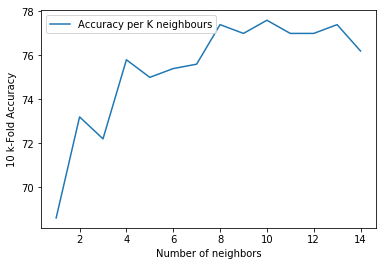

In [71]:
#You can also identify the optimum K from plotting the accuracy list by completing the following steps:
from matplotlib import pyplot as plt

#Plot the result by using the following code:

plt.plot(range(1,15),accuracy_list_for_each_K_neighbours)
plt.legend(['Accuracy per K neighbours'], loc='upper left')
plt.xlabel("Number of neighbors")
plt.ylabel("10 k-Fold Accuracy")
plt.show()